 # Feature Extraction
 ## Imports
 General stuff

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft
import os
import pathlib

# Audio processing/tools import
import librosa
import librosa.display
from scipy.io.wavfile import read 
from IPython.display import Audio
# REMEMBER you need ffmpeg installed

# Parellization libraries
from joblib import Parallel, delayed

# Import custom module containing useful functions
import sonicboom

# Import helper functions
import time


 ## Define some constants

In [11]:
SAVEPATH = './output/intermediate-data/'
#FILEDESC = 'filedata-librosaFeatures.pkl'
FILEDESC = 'filedata-librosaConventionalFeatures.pkl'


 ## Read and add filepaths to original UrbanSound metadata

In [12]:
filedata = sonicboom.init_data('./data/UrbanSound8K/')


Calling 'init_data'
Finished 'init_data' in 0.0857 secs


 ## Sample down

In [13]:
sampleDown = False

# samples down grouping by class - this gives me X items from each class.
# as_index=False is important because otherwise,
# Pandas calls the index and the column the same thing, confusing itself
if (sampleDown == True):
    filedata = filedata.groupby(
        'class', 
        as_index=False, 
        group_keys=False
    ).apply(lambda x: x.sample(n=2, random_state=0))

# check that the sample down is working
# as_index=False is important because otherwise,
# Pandas calls the index and the column the same thing, confusing itself
filedata.groupby('class', as_index=False)['slice_file_name'].nunique()


0    1000
1     429
2    1000
3    1000
4    1000
5    1000
6     374
7     999
8     929
9    1000
Name: slice_file_name, dtype: int64

 ## Read one audio file to see what it contains

Calling 'test_read_audio'
Calling 'load_audio'
Finished 'load_audio' in 0.0033 secs


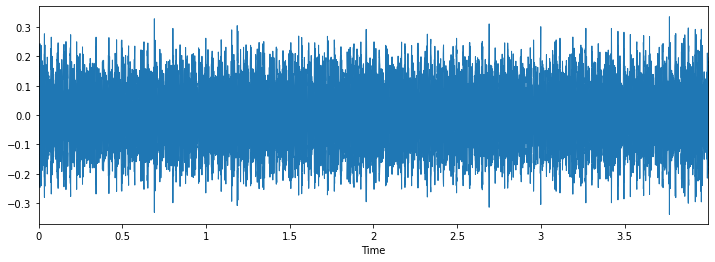

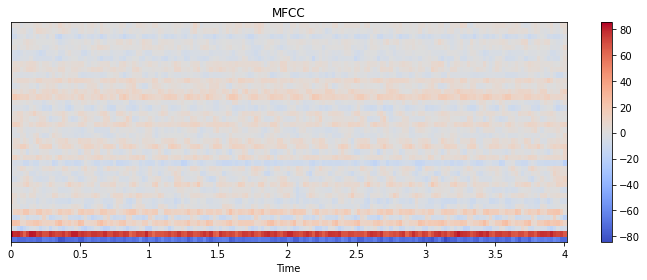

Finished 'test_read_audio' in 0.3507 secs


In [14]:
sonicboom.test_read_audio(filedata.path.iloc[0])


In [15]:
# Get sample rates for all .wave files and add to filedata dataframe

#filedata['Sample Rate'] = Parallel(n_jobs=-1)(delayed(sonicboom.samplerate)(x) for x in filedata['path'])

#filedata.to_csv('./SampleRates.csv')


 ## PARALLEL Generate features and add to dataframe

In [16]:
startTime = time.perf_counter()

#non-parallel version
#filedata['mfccs'] = [sonicboom.mfccsEngineering(x) for x in filedata['path']]

# inputVar = input("0. All, \n \
#     1. MFCCS \n \
#     2. Mel-scaled spectrogram \n \
#     3. Short-time Fourier transform (STFT) \n \
#     4. Chromagram (STFT) \n \
#     5. Spectral contrast (STFT) \n \
#     6. Tonal centroid features (tonnetz) from harmonic components \n")
#     7. Vis's custom FFT feature

mfccs_exec = True
melSpec_exec = True
stft_exec = False #too many elements, array is huge, cannot be flattened
chroma_stft_exec = True 
spectral_contrast_stft_exec = True
tonnetz_exec = True
visFFT_exec = False #huge, cannot be flattened
mfccDelta_exec = False #for neural network only, cannot be normalized
flatten = True
normalize = True

tempDF = pd.DataFrame() 

tempDF = pd.concat(Parallel(n_jobs=-1)(delayed(sonicboom.generateFeatures) \
    (x, mfccs_exec, melSpec_exec, stft_exec, chroma_stft_exec, \
        spectral_contrast_stft_exec, tonnetz_exec, visFFT_exec, mfccDelta_exec, \
        flatten, normalize) for x in filedata['path']))

filedata = filedata.join(tempDF.set_index('path'), on='path')

endTime = time.perf_counter()
runTime = endTime - startTime
print(f'Finished in {runTime:.4f} secs')

filedata.head()


Finished in 306.3501 secs


,path,slice_file_name,fsID,start,end,salience,fold,classID,class,mfccs,melSpec,chroma_stft,spectral_contrast_stft,tonnetz
0,data/UrbanSound8K/audio/fold3/195451-5-0-21.wav,195451-5-0-21.wav,195451,12.749062,16.749062,1,3,5,engine_idling,"[0.0, 1.0, 0.4437291, 0.59153306, 0.45830166, ...","[0.5128107, 0.9999999, 0.16205902, 0.07680624,...","[0.0, 0.098377876, 0.48215958, 0.82687426, 0.9...","[0.9848953492056421, 0.04095642911002232, 0.0,...","[0.0, 0.19750059281700416, 0.12797810698686948..."
1,data/UrbanSound8K/audio/fold3/112075-5-0-2.wav,112075-5-0-2.wav,112075,9.037355,13.037355,2,3,5,engine_idling,"[0.046528116, 1.0, 0.15096846, 0.42279488, 0.1...","[0.003973532, 0.038080055, 0.12683089, 0.74289...","[0.13973394, 0.17169072, 0.35754606, 0.9999974...","[0.999999882334079, 0.23397555009182935, 0.190...","[0.3170768093096214, 0.1630069259627819, 0.0, ..."
2,data/UrbanSound8K/audio/fold3/98681-9-0-12.wav,98681-9-0-12.wav,98681,6.000000,10.000000,2,3,9,street_music,"[0.0, 1.0, 0.566404, 0.75245655, 0.7023444, 0....","[0.07280028, 0.113039434, 0.05909347, 0.041520...","[0.37964487, 0.0, 0.37939143, 0.21343386, 0.39...","[0.0, 0.10896364935510458, 0.428032863770412, ...","[0.9881043882607795, 0.6284331586202113, 0.999..."
3,data/UrbanSound8K/audio/fold3/165039-7-11-0.wav,165039-7-11-0.wav,165039,142.280541,146.280541,1,3,7,jackhammer,"[0.0, 1.0, 0.5009636, 0.7033996, 0.4991666, 0....","[0.21449894, 0.92175645, 0.99999994, 0.7986757...","[0.75837964, 0.99999404, 0.63529855, 0.7780573...","[0.6674096293487833, 0.0, 0.3552743805022218, ...","[0.838027328973501, 0.6827474238051907, 0.0, 0..."
4,data/UrbanSound8K/audio/fold3/103199-4-0-3.wav,103199-4-0-3.wav,103199,1.500000,5.500000,1,3,4,drilling,"[0.3217654, 1.0, 0.0, 0.54690635, 0.47653884, ...","[0.0040449547, 0.0016131944, 0.001222729, 0.00...","[0.38465875, 0.2692769, 0.0, 0.26744914, 0.606...","[0.019249639681011364, 0.2645240905596094, 0.1...","[0.5379112844834538, 0.295805337385854, 0.0, 0..."


 ## Save the generated features

In [17]:
filedata.to_pickle(SAVEPATH + FILEDESC)


In [18]:
filedata.shape

(8731, 14)